## 4.1 Analysing the problem of imbalance

In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
plt.rcParams['font.size'] = 14
plt.style.use('seaborn-whitegrid')

In [33]:
df = pd.read_csv('cleaned_data/Cleaned Data.csv',index_col=[0])

In [36]:
df['Signal'].value_counts()

Sell    6153
Buy     4681
Hold     745
Name: Signal, dtype: int64

In [109]:
SignalFac = []

for string in df['Signal']:
    if string == 'Sell':
        SignalFac.append(0)
    elif string == 'Hold':
        SignalFac.append(1)    
    else:
        SignalFac.append(2)

In [110]:
df['SignalFac'] = SignalFac

In [111]:
y = df['SignalFac']
X = df.drop(['Signal','SignalFac'], axis=1)

In [112]:
print('Sell hat', X[y==0].shape[0], 'Werte')
print('Hold hat', X[y==1].shape[0], 'Werte')
print('Buy hat', X[y==2].shape[0], 'Werte')

Sell hat 6153 Werte
Hold hat 745 Werte
Buy hat 4681 Werte


In [128]:
#Upsampling of Hold to the number of Sell

from sklearn.utils import resample

X_upsampled, y_upsampled = resample(X[y==1], y[y==1],
                                    replace=True,
                                    n_samples=5408,
                                    random_state=1)

In [129]:
# Combine datasets
X_bal = np.vstack((X, X_upsampled))
y_bal = np.hstack((y, y_upsampled))

In [130]:
#Upsampling of Buy to the number of Sells

from sklearn.utils import resample

X_dnsampled, y_dnsampled = resample(X[y==2], y[y==2],
                                    replace=True,
                                    n_samples=1472,
                                    random_state=1)

In [131]:
# Combine datasets
X_bal = np.vstack((X_bal, X_dnsampled))
y_bal = np.hstack((y_bal, y_dnsampled))

In [132]:
pd.value_counts(pd.DataFrame(y_bal)[0])

2    6153
1    6153
0    6153
Name: 0, dtype: int64

In [133]:
print(X_bal.shape)
print(y_bal.shape)

(18459, 230)
(18459,)


In [134]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = \
    train_test_split(X_bal, y_bal, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y_bal)

In [135]:
from sklearn.ensemble import RandomForestClassifier

# Create classifier object and fit it to data
forest = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)
forest.fit(X_train_bal, y_train_bal)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [136]:
y_pred = forest.predict(X_test_bal)

In [137]:
print(classification_report(y_test_bal,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1846
           1       0.98      1.00      0.99      1846
           2       0.68      0.63      0.65      1846

    accuracy                           0.77      5538
   macro avg       0.77      0.77      0.77      5538
weighted avg       0.77      0.77      0.77      5538



In [138]:
print('Confusion matrix: \n', 
      metrics.confusion_matrix(y_test_bal,y_pred))

Confusion matrix: 
 [[1273   17  556]
 [   4 1842    0]
 [ 655   28 1163]]


## 4.1. Selecting features based on our academic education

We categorized 6 groups of kpi's based on our education that should have an predictive characteristic for the return. We would like to see if our model is able to increase its performance with limiting the amount of features.

### Multiples
* EV/EBITDA (Enterprise Value over EBITDA)
* P/E (PE ratio)
* Price Earnings to Growth Ratio

### Carhart Model
* Price-to-book (priceToBookRatio)
* Momentum (3Y Shareholders Equity Growth (per Share))
* Market Cap

### Income Statement
* Revenue
* Revenue Growth
* Gross Margin
* R&D to Revenue

### Balance
* Debt to Equity (debtEquityRatio)
* Long-term investments
* Goodwill and Intangible Assets

### Additional
* ROIC
* ROE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
df = pd.read_csv('cleaned_data/Cleaned Data.csv', index_col=[0])

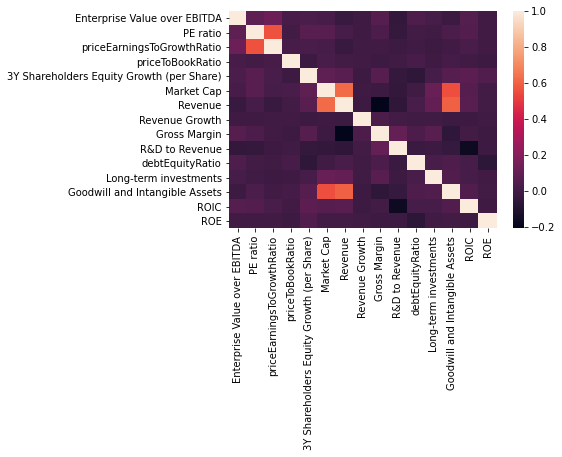

In [4]:
#Checking for Multicolinearity among Features
dfn = df[[
    'Enterprise Value over EBITDA','PE ratio','priceEarningsToGrowthRatio',
    'priceToBookRatio','3Y Shareholders Equity Growth (per Share)', 'Market Cap',
    'Revenue', 'Revenue Growth', 'Gross Margin', 'R&D to Revenue', 
    'debtEquityRatio', 'Long-term investments', 'Goodwill and Intangible Assets', 
    'ROIC', 'ROE',
    'Signal']]
sns.heatmap(dfn.corr(), annot=False)

In [5]:
#Seems good

In [6]:
#Assigning values
X = dfn.drop('Signal', axis=1)
y = dfn['Signal']

In [7]:
# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [8]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [9]:
# Max depth
maxDepth = np.array([1, 2, 5, 10])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2, 5, 10])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([10, 20, 30])

# Import necessary functions
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Create k-Fold CV object
kFold = StratifiedKFold(n_splits=10)

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter values to be tested
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': maxDepth,
              'min_samples_split': minSamplesNode,
              'min_samples_leaf': minSamplesLeaf}

# Run brute-force grid search
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=kFold, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5634776453395441
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [11]:
# Extract best parameter
clf = gs.best_estimator_

# Fit model given best parameter
clf.fit(X_train, y_train)

# Print out score on Test dataset
print('Test accuracy: {0: .4f}'.format(clf.score(X_test, y_test)))

Test accuracy:  0.5521


In [12]:
from sklearn import metrics

y_pred = tree.predict(X_test)
print('Confusion matrix: \n', 
      metrics.confusion_matrix(y_test, y_pred))

Confusion matrix: 
 [[ 429    0  975]
 [  64    0  160]
 [ 329    0 1517]]


## Random Forest 

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Create classifier object and fit it to data
forest = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [14]:
y_pred = forest.predict(X_test)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         Buy       0.50      0.40      0.45      1404
        Hold       0.17      0.00      0.01       224
        Sell       0.58      0.74      0.65      1846

    accuracy                           0.56      3474
   macro avg       0.42      0.38      0.37      3474
weighted avg       0.52      0.56      0.53      3474



In [ ]:
# No Improvement

## 4.2 Analysing the problem of imbalance

In [29]:
#Upsampling of Hold to the number of buys

In [ ]:
SignalFac = []

for string in df['Signal']:
    if string == 'Sell':
        SignalFac.append(0)
    elif string == 'Hold':
        SignalFac.append(1)    
    else:
        SignalFac.append(2)

In [27]:
X = df.drop('Signal', axis=1)
y = df['Signal']

In [28]:
print('Sell hat', X[y==0].shape[0], 'Werte')
print('Hold hat', X[y==1].shape[0], 'Werte')
print('Buy hat', X[y==2].shape[0], 'Werte')

Sell hat 0 Werte
Hold hat 0 Werte
Buy hat 0 Werte
